In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn 
import math
import scipy
import statsmodels.formula.api as smf
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model
from sklearn import model_selection
from statsmodels.sandbox.regression.predstd import wls_prediction_std
%matplotlib inline

In [2]:
#import data and provide friendly column names
crime_raw = pd.read_csv('georgia_crime.csv')
crime_raw.rename(columns={'City': 'city',
                         'Population': 'population',
                         'Violent\ncrime': 'violent_crime',
                         'Murder and\nnonnegligent\nmanslaughter': 'murder',
                         'Rape\n(revised\ndefinition)1': 'rape_legacy',
                         'Rape\n(legacy\ndefinition)2': 'rape',
                         'Robbery': 'robbery',
                         'Aggravated\nassault': 'aggravated_assault',
                         'Property\ncrime': 'property_crime',
                         'Burglary': 'burglary',
                         'Larceny-\ntheft': 'larceny_theft',
                         'Motor\nvehicle\ntheft': 'vehicle_theft',
                         'Arson3': 'arson',
                         'Unnamed: 13': 'unnamed'}, inplace=True)

In [3]:
#drop columns with no data and final 3 rows, which were footnotes
crime_raw.drop(['rape_legacy', 'unnamed'], axis=1, inplace=True)
crime_raw.drop(crime_raw.index[-3:], inplace=True)

In [4]:
#remove commas from all columns with them, and change all numerics to floats
cols = crime_raw.columns.drop('city')

crime_raw['population'] = crime_raw['population'].str.replace(',', '')
crime_raw['violent_crime'] = crime_raw['violent_crime'].str.replace(',', '')
#crime_raw['rape'] = crime_raw['rape'].str.replace(',', '')
crime_raw['robbery'] = crime_raw['robbery'].str.replace(',', '')
crime_raw['aggravated_assault'] = crime_raw['aggravated_assault'].str.replace(',', '')
crime_raw['property_crime'] = crime_raw['property_crime'].str.replace(',', '')
crime_raw['burglary'] = crime_raw['burglary'].str.replace(',', '')
crime_raw['larceny_theft'] = crime_raw['larceny_theft'].str.replace(',', '')
crime_raw['vehicle_theft'] = crime_raw['vehicle_theft'].str.replace(',', '')
crime_raw[cols] = crime_raw[cols].astype(float)
#drop city names and fill other NaN data with 0
crime_raw = crime_raw.drop('city', 1)
crime_raw[cols] = crime_raw[cols].fillna(0)
#set property crime as target and everything else as features
raw_target = crime_raw['property_crime']
raw_features = crime_raw.drop('property_crime', 1)

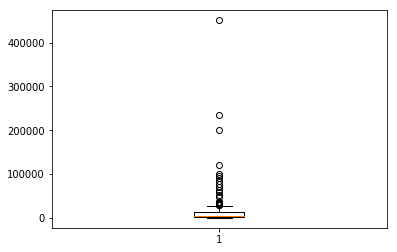

In [5]:
#popluation boxplot
plt.boxplot(crime_raw['population'])
plt.show()

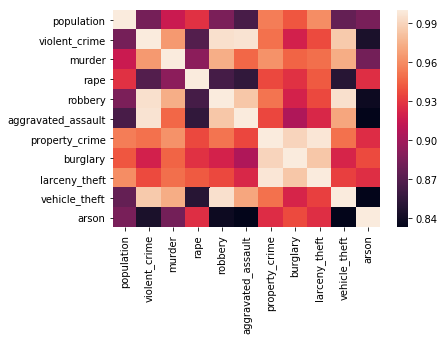

In [6]:
#correlation heatmap raw data
sns.heatmap(crime_raw.corr())
plt.show()

In [7]:
#removing population outliers
q = crime_raw['population'].quantile(0.99)

crime_raw = crime_raw[crime_raw['population'] < q]

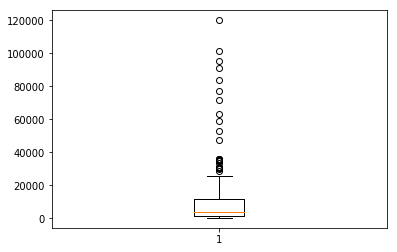

In [8]:
plt.boxplot(crime_raw['population'])
plt.show()

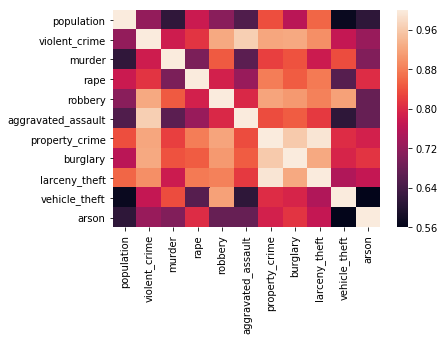

In [9]:
sns.heatmap(crime_raw.corr())
plt.show()

In [10]:
#creating a new data frame with just 2 features
crime_df = pd.DataFrame()
crime_df['property_crime'] = crime_raw['property_crime']
crime_df['burglary'] = crime_raw['burglary']
#crime_df['robbery'] = crime_raw['robbery']
crime_df['vehicle_theft'] = crime_raw['vehicle_theft']

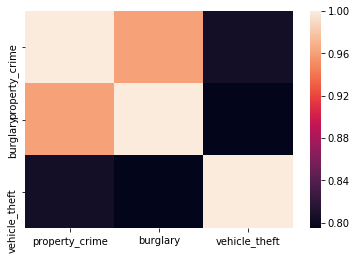

In [11]:
sns.heatmap(crime_df.corr())
plt.show()

In [12]:
#log transform the new data frame to balance residuals and drop -inf values
crime_df = crime_df.apply(np.log)
crime_df = crime_df[~crime_df.isin([-np.inf]).any(1)]

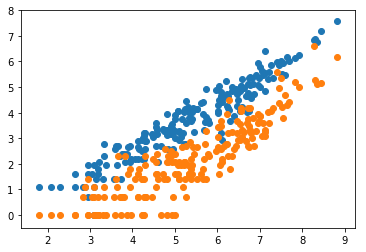

In [13]:
plt.scatter(crime_df['property_crime'], crime_df['burglary'])
#plt.scatter(crime_df['property_crime'], crime_df['robbery'])
plt.scatter(crime_df['property_crime'], crime_df['vehicle_theft'])
plt.show()

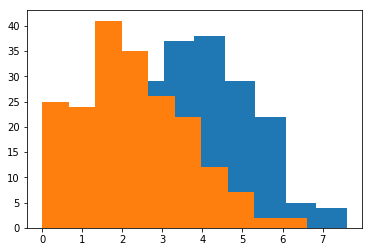

In [14]:
plt.hist(crime_df['burglary'])
#plt.hist(crime_df['robbery'])
plt.hist(crime_df['vehicle_theft'])

plt.show()

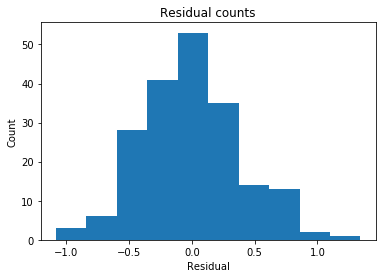

In [15]:
regr = linear_model.LinearRegression()
Y = crime_df['property_crime'].values.reshape(-1, 1)
X = crime_df.drop('property_crime', 1)
regr.fit(X, Y)
predicted = regr.predict(X).ravel()
actual = crime_df['property_crime']
residual = actual - predicted

plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

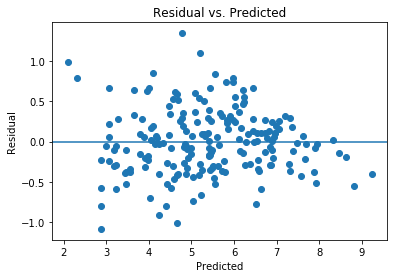

In [16]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [17]:
#linear regression with features
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[ 0.69982329  0.29186421]]

Intercept: 
 [ 2.10447211]

R-squared:
0.922997087734


In [18]:
#pca on the raw data with all 10 features
target = crime_raw.property_crime
features = crime_raw.drop('property_crime', 1)
x = StandardScaler().fit_transform(features)
#select 2 components to run
pca = PCA(n_components=2, svd_solver='auto')
prinComp = pca.fit_transform(x)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    pca.explained_variance_ratio_,
    '\n',
    np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [ 0.80159957  0.06555863] 
 [ 80.16  86.72]


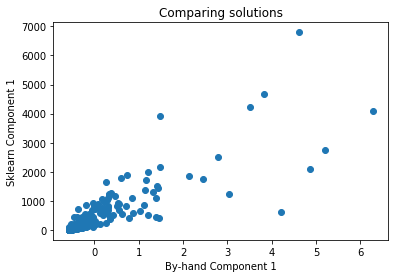

In [19]:
plt.plot(x[:, 0], target, 'o')
plt.title('Comparing solutions')
plt.ylabel('Sklearn Component 1')
plt.xlabel('By-hand Component 1')
plt.show()

In [20]:
linear_formula = 'property_crime ~ burglary+vehicle_theft'
lm = smf.ols(formula=linear_formula, data=crime_df).fit()

In [21]:
lm.params

Intercept        2.104472
burglary         0.699823
vehicle_theft    0.291864
dtype: float64

In [22]:
lm.pvalues

Intercept        3.000985e-59
burglary         1.603723e-44
vehicle_theft    7.810781e-13
dtype: float64